# Opening atomic and nuclear data files in dryad

Dryad is meant to be a format agnostic interface that supports multiple formats and even allows users to quickly develop their own data format for their purposes.

## ProjectileTarget

All data for a particle interacting with a target are stored in a ```ProjectileTarget``` object. These projectile-target data sets can be used to describe both atomic and nuclear interactions using the same interface.

A ```ProjectileTarget``` can currently be created from a ENDF6, GNDS and ACE formatted data files. A number of dedicated factory functions for each supported format are defined in the ```ProjectileTarget``` interface:
- ```from_endf_file``` for ENDF6 formatted files
- ```from_gnds_file``` for GNDS 2.0 formatted xml files
- ```from_ace_file``` for ACE formatted files
The only input required for these functions are the name and path (relative or absolute) of the file.

For example:

In [1]:
import dryad

pt_gnds = dryad.ProjectileTarget.from_gnds_file( 'resources/gnds/n-004_Be_009.endf.gnds.xml' )
pt_endf = dryad.ProjectileTarget.from_endf_file( 'resources/endf/n-004_Be_009.endf' )

A ```ProjectileTarget``` instance provides the following information:
- the projectile and target identifier (```projectile_identifier``` and ```target_identifier```)
- the interaction type (```interaction_type```), which is either atomic or nuclear
- optional resonance parameter data (```resonances```), which is currently just a placeholder
- a set of reactions (```reactions```)

The interface also provides a ```has_reaction(id)``` function to check whether or not a given reaction is present and a ```reaction(id)``` function that can be used to extract a specific reaction (an exception is thrown if the reaction cannot be found).

Reaction data is stored in a ```Reaction``` object, which provides the following information:
- the reaction identifier (```identifier```)
- the reaction category (```category```), which is either primary or summation
- the partial reaction identifiers (```partial_reaction_identifiers```), which is undefined if the reaction is not a summation reaction
- the Q values (```mass_difference_qvalue``` and ```reaction_qvalue```), which are only defined for primary reactions (Q values for summation reactions are not defined).
- the cross section data (```cross_section```)
- a set of reaction products (```products```)

The ```Reaction``` interface also provides a number of auxiliary functions related to the reaction products:
- the total number of reaction products defined for the reaction (```number_products()```) or the number of reaction products of a given type defined for the reaction (```number_products(type)```)
- the number of products defined for the reaction of a given particle type (```has_product(type)```)
- retrieve a reaction product of the given type (```product(type,index)```)

The ```product(type,index)``` function can be used to extract a reaction product of the given type and given index within that type. An exception is thrown if the product cannot be found. If the ```index``` value is not defined in a call to this function, the first reaction product of the requested type will be returned if it is defined.

Note: when reading GNDS files, only the ```reaction_qvalue``` is defined. For ENDF6 formatted files, both the ```reaction_qvalue``` and the ```mass_difference_qvalue``` are defined. In the future, dryad will provide a function to calculate the mass difference Q value if it is missing (this is a feature we would need if we want to go from GNDS to ENDF6).

## Example: reading GNDS data for Be9 and printing out some metadata

In this example we will open a GNDS file for ENDF/B-VIII.1 n+Be9 and print out an overview of some of the available information.

In [2]:
import dryad

# open a GNDS file for n+Be9
pt = dryad.ProjectileTarget.from_gnds_file( 'resources/gnds/n-004_Be_009.endf.gnds.xml' )

# print an over view of the content of the file
print( 'projectile: {}'.format( pt.projectile_identifier ) )
print( 'target    : {}'.format( pt.target_identifier ) )
print( 'interaction type: {}'.format( pt.interaction_type ) )

print( 'available reactions' )
print( '- - - - - - - - - -' )
for reaction in pt.reactions :

    print( 'reaction: {}'.format( reaction.identifier ) )
    print( '  category: {}'.format( reaction.category ) )
    for product in reaction.products :

        print( '  product: {}'.format( product.identifier ) )

projectile: n
target    : Be9
interaction type: InteractionType.Nuclear
available reactions
- - - - - - - - - -
reaction: 1
  category: ReactionCategory.Summation
reaction: 2
  category: ReactionCategory.Primary
  product: n
  product: Be9
reaction: 3
  category: ReactionCategory.Summation
reaction: 16
  category: ReactionCategory.Primary
  product: n
  product: He4
reaction: 102
  category: ReactionCategory.Primary
  product: Be10
  product: g
  product: g
  product: g
  product: g
  product: g
  product: g
  product: g
  product: g
  product: g
  product: g
  product: g
reaction: 103
  category: ReactionCategory.Summation
reaction: 104
  category: ReactionCategory.Summation
reaction: 105
  category: ReactionCategory.Summation
reaction: 107
  category: ReactionCategory.Summation
reaction: 600
  category: ReactionCategory.Primary
  product: H1
  product: Li9
reaction: 650
  category: ReactionCategory.Primary
  product: H2
  product: Li8
reaction: 700
  category: ReactionCategory.Primar

## Example: extracting and plotting cross section data

In this example, we extract and plot some n+Be9 cross section data.

In [2]:
import dryad

# open a GNDS file for n+Be9
pt = dryad.ProjectileTarget.from_gnds_file( 'resources/gnds/n-004_Be_009.endf.gnds.xml' )

# identifiers
elastic_id = dryad.id.ReactionID( 'n,Be9->n,Be9' )
capture_id = dryad.id.ReactionID( 'n,Be9->g,Be10[all]' )
total_id = dryad.id.ReactionID( 'n,Be9->total' )

# extract cross section data
elastic = pt.reaction( elastic_id ).cross_section
capture = pt.reaction(capture_id ).cross_section
total = pt.reaction( total_id ).cross_section

# note: the capture cross section is not linearised:
print( 'elastic is linearised? {}'.format( elastic.is_linearised ) )
print( 'capture is linearised? {}'.format( capture.is_linearised ) )
print( 'total is linearised? {}'.format( total.is_linearised ) )

# the capture cross section can be linearised as follows:
capture = capture.linearise()

# note: the capture cross section is now linearised:
print( 'elastic is linearised? {}'.format( elastic.is_linearised ) )
print( 'capture is linearised? {}'.format( capture.is_linearised ) )
print( 'total is linearised? {}'.format( total.is_linearised ) )

elastic is linearised? True
capture is linearised? False
total is linearised? True
elastic is linearised? True
capture is linearised? True
total is linearised? True


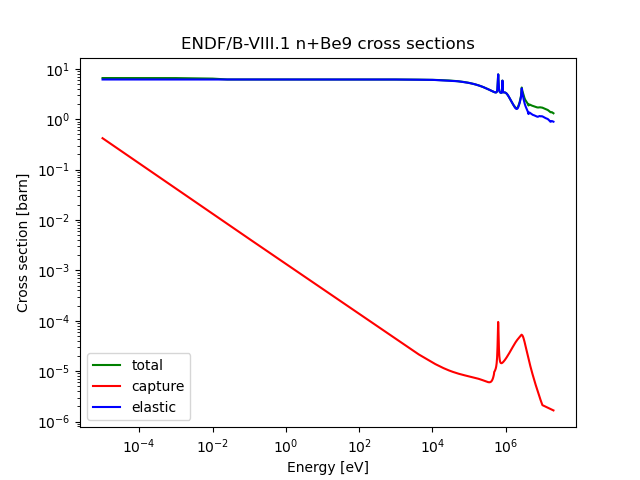

In [4]:
import matplotlib.pyplot as plot
%matplotlib widget

plot.figure()
plot.plot( total.energies, total.values, label = 'total', color = 'green', linewidth = 1.5 )
plot.plot( capture.energies, capture.values, label = 'capture', color = 'red', linewidth = 1.5 )
plot.plot( elastic.energies, elastic.values, label = 'elastic', color = 'blue', linewidth = 1.5 )
plot.title( 'ENDF/B-VIII.1 n+Be9 cross sections' )
plot.xlabel( 'Energy [eV]' )
plot.ylabel( 'Cross section [barn]' )
plot.xscale( 'log' )
plot.yscale( 'log' )
plot.legend()
plot.show()


## Example: plotting angular distribution data for elastic scattering

In this example, we will plot angular distribution for elastic scattering. In this case, the ENDF/B-VIII.1 n+Be9 data in GNDS and ENDF6 define these as a set of Legendre moments (MF4 LTT=1 in ENDF speak). Internally dryad will transform these Legendre moments into a set of Legendre coefficients that defines the angular distribution.

In [5]:
import dryad

# open a GNDS file for n+Be9 and get the elastic reaction data
pt = dryad.ProjectileTarget.from_gnds_file( 'resources/gnds/n-004_Be_009.endf.gnds.xml' )
elastic = pt.reaction('2')

# get the angular distribution data for neutrons from elastic
neutron = dryad.id.ParticleID.neutron()
angular = elastic.product(neutron).distribution_data.angle

# extract a number of pdfs and linearise them
# note: the pdfs are linearised but are currently not renormalised so that they integrate to 1
energy1 = angular.grid[8]
linearised1 = angular.distributions[8].pdf.linearise()

energy2 = angular.grid[66]
linearised2 = angular.distributions[66].pdf.linearise()

energy3 = angular.grid[-1]
linearised3 = angular.distributions[-1].pdf.linearise()

# note: cdfs are also available when the data is represented as Legendre series

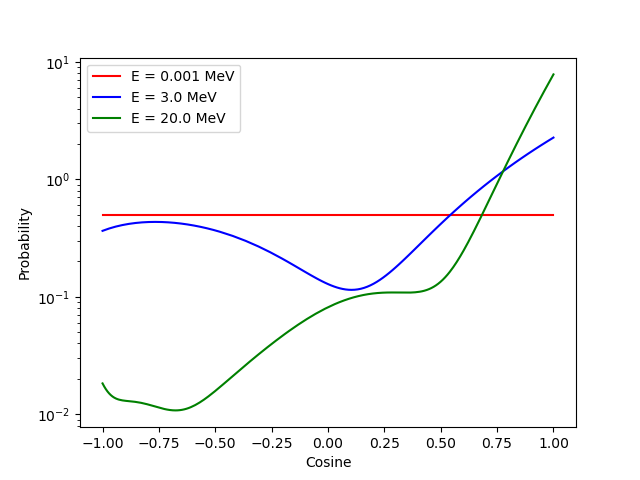

In [6]:
import matplotlib.pyplot as plot
%matplotlib widget

plot.figure()
plot.plot( linearised1.cosines, linearised1.values, label = 'E = {} MeV'.format( energy1 / 1e+6 ),
            color = 'red', linewidth = 1.5 )
plot.plot( linearised2.cosines, linearised2.values, label = 'E = {} MeV'.format( energy2 / 1e+6 ),
            color = 'blue', linewidth = 1.5 )
plot.plot( linearised3.cosines, linearised3.values, label = 'E = {} MeV'.format( energy3 / 1e+6 ),
            color = 'green', linewidth = 1.5 )
plot.xlabel( 'Cosine' )
plot.ylabel( 'Probability' )
plot.xscale( 'linear' )
plot.yscale( 'log' )
plot.legend()
plot.show()

## Example: calculating some derived data

Average energy or cosine data can be calculated from the available distribution data. For example, the average cosine data can be calculated for elastic scattering from both the Legendre representation directly or after linearising the data.

In [7]:
import dryad

# open a GNDS file for n+Be9 and get the elastic reaction data
pt = dryad.ProjectileTarget.from_gnds_file( 'resources/gnds/n-004_Be_009.endf.gnds.xml' )
elastic = pt.reaction('2')

# get the angular distribution data for neutrons from elastic
neutron = dryad.id.ParticleID.neutron()
angular = elastic.product(neutron).distribution_data.angle

# request the mubar data (this is calculated when the data is requested)
average_legendre = angular.average_cosines
average_linearised = angular.linearise().average_cosines


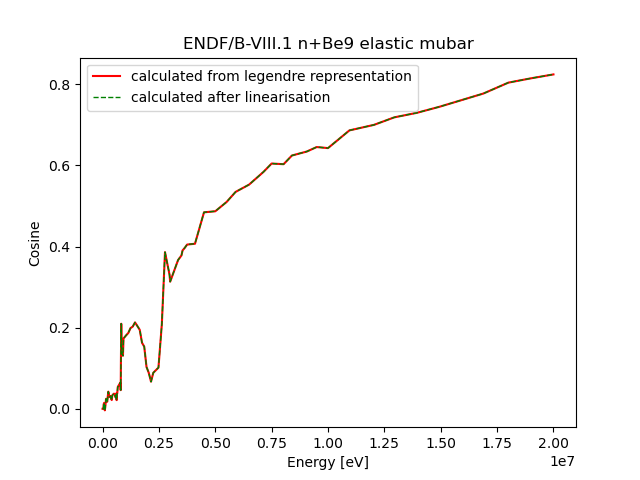

In [8]:
import matplotlib.pyplot as plot
%matplotlib widget

plot.figure()
plot.plot( average_legendre.energies, average_legendre.values,
           color = 'red', linewidth = 1.5, label = 'calculated from legendre representation' )
plot.plot( average_linearised.energies, average_linearised.values,
           color = 'green', linewidth = 1., linestyle = '--', label = 'calculated after linearisation' )
plot.title( 'ENDF/B-VIII.1 n+Be9 elastic mubar' )
plot.xlabel( 'Energy [eV]' )
plot.ylabel( 'Cosine' )
plot.xscale( 'linear' )
plot.yscale( 'linear' )
plot.legend()
plot.show()
